# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-20 18:30:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [      <=>           ] 201.24M  62.2MB/s    in 8.2s    

2024-10-20 18:30:26 (24.6 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [46]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [47]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [48]:
set_random_seed(42)

In [49]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [9]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
model = linear_model.Ridge()
model.fit(X_train, y_train)

pred_for_model = model.predict(X_test)
rmse_for_model = mean_squared_error(y_test, pred_for_model, squared=False)
print("RMSE: " , rmse_for_model)

RMSE:  9.51267116131314


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
best_rmse_metric = mean_squared_error(y_test, np.array([np.mean(y_train)] * len(y_test)), squared=False)
print("The RMSE is: " , best_rmse_metric)

The RMSE is:  10.85246390513634


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

input_dim = X_train.shape[1]
model = LinearRegressionModel(input_dim)

In [ ]:
train_losses = []
test_losses = []

for epoch in range(10):
    y_pred_train = model(X_train_tensor)
    rmse = ((y_pred_train - y_train_tensor) ** 2).mean()
    train_loss = torch.sqrt(rmse)
    train_losses.append(train_loss.item())

    train_loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= 0.05 * param.grad

    model.zero_grad()

    y_pred_test = model(X_test_tensor)
    rmse = ((y_pred_test - y_test_tensor) ** 2).mean()
    test_loss = torch.sqrt(rmse)
    test_losses.append(test_loss.item())

    print(f'Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch 1, Train Loss: 1998.3939, Test Loss: 1998.4531
Epoch 2, Train Loss: 1998.3440, Test Loss: 1998.4031
Epoch 3, Train Loss: 1998.2939, Test Loss: 1998.3531
Epoch 4, Train Loss: 1998.2440, Test Loss: 1998.3031
Epoch 5, Train Loss: 1998.1940, Test Loss: 1998.2529
Epoch 6, Train Loss: 1998.1439, Test Loss: 1998.2031
Epoch 7, Train Loss: 1998.0940, Test Loss: 1998.1531
Epoch 8, Train Loss: 1998.0438, Test Loss: 1998.1030
Epoch 9, Train Loss: 1997.9939, Test Loss: 1998.0531
Epoch 10, Train Loss: 1997.9440, Test Loss: 1998.0031


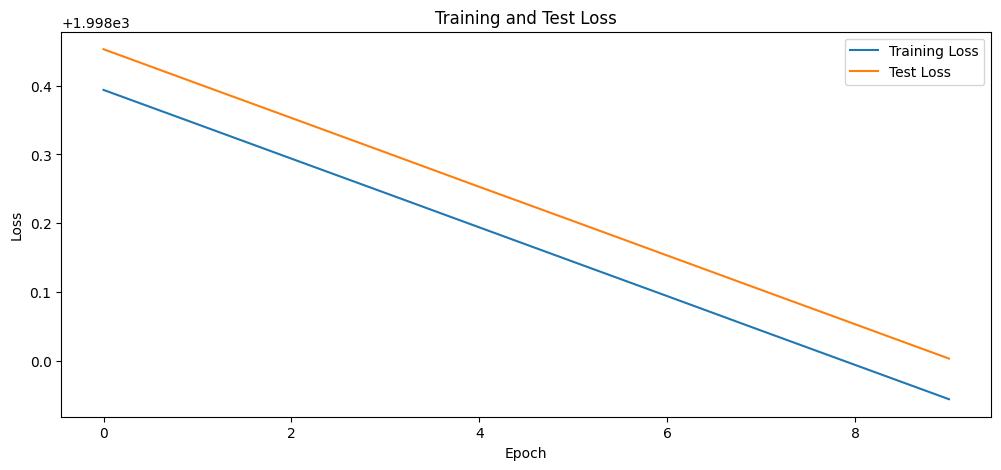

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [50]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error

In [51]:
# нормализация таргета
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

In [52]:
set_random_seed(42)

In [53]:
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [54]:
train_set = CustomDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_set = CustomDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [55]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(X.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.fc(x)

In [56]:
def train(model, optimizer, criterion, train_loader, test_loader, epochs=5):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.show()

def test(model, criterion, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            preds = model(inputs).squeeze()
            predictions.append(preds)

    predictions = torch.cat(predictions).cpu().numpy()
    return predictions

In [57]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

Epoch 1, Train Loss: 0.6630, Test Loss: 0.6542
Epoch 2, Train Loss: 0.6322, Test Loss: 0.6507
Epoch 3, Train Loss: 0.6221, Test Loss: 0.6488
Epoch 4, Train Loss: 0.6145, Test Loss: 0.6466
Epoch 5, Train Loss: 0.6101, Test Loss: 0.6450


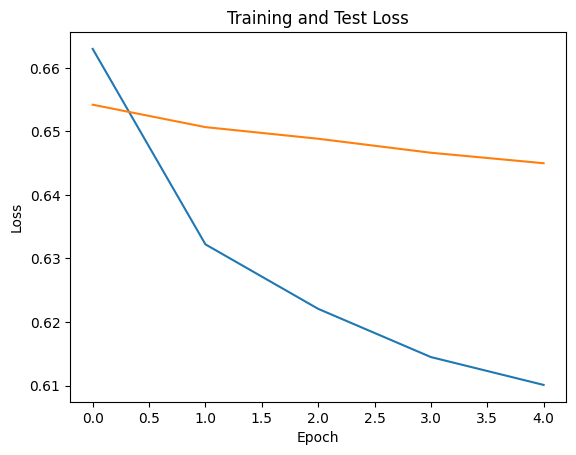

RMSE: 8.7869


In [58]:
train(model, optimizer, criterion, train_loader, test_loader)

y_pred_scaled = test(model, criterion, test_loader)

y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse:.4f}')

In [ ]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Сначала была построена простая полносвязная нейронная сеть с двумя слоями и функцией активации ReLU.

Оптимизатор - SGD с параметрами lr=0.001, momentum=0.9, batch_size = 32. Количество эпох - 10. Полученные результаты: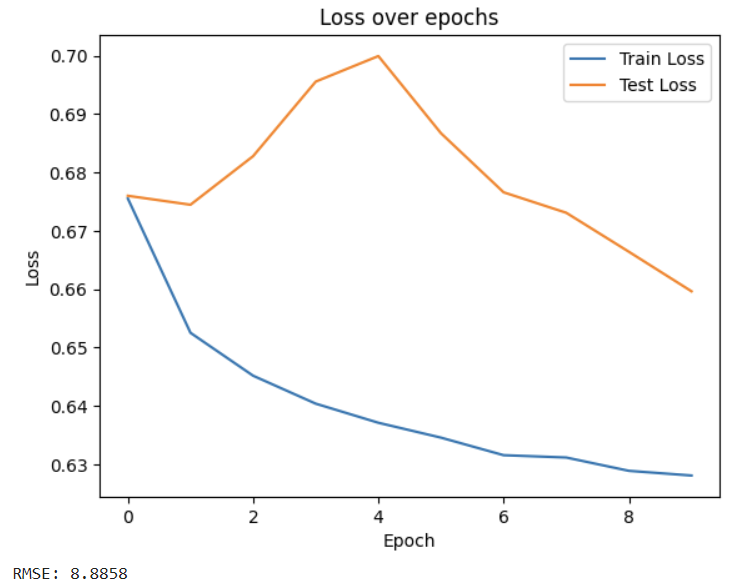




Попробуем поменять оптимизатор на optim.Adam с тем же learing rate 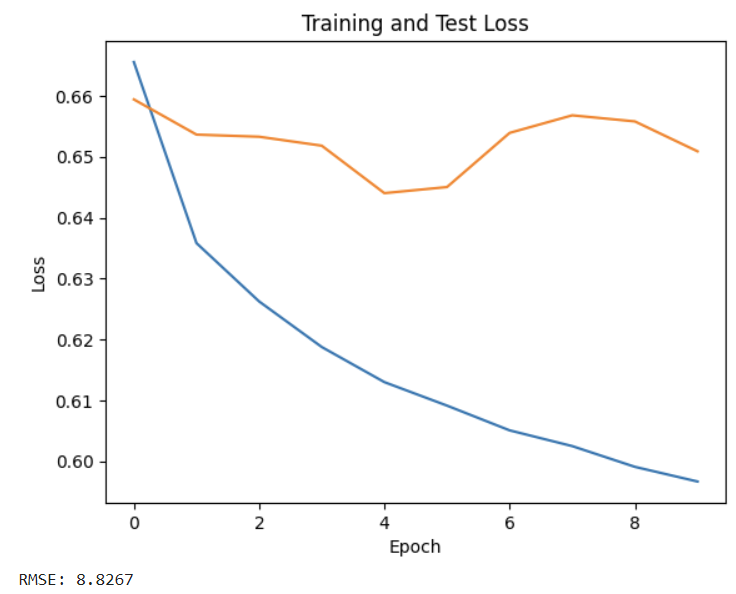

Качество улучшилось. Добавим Dropout вероятностью 0.5 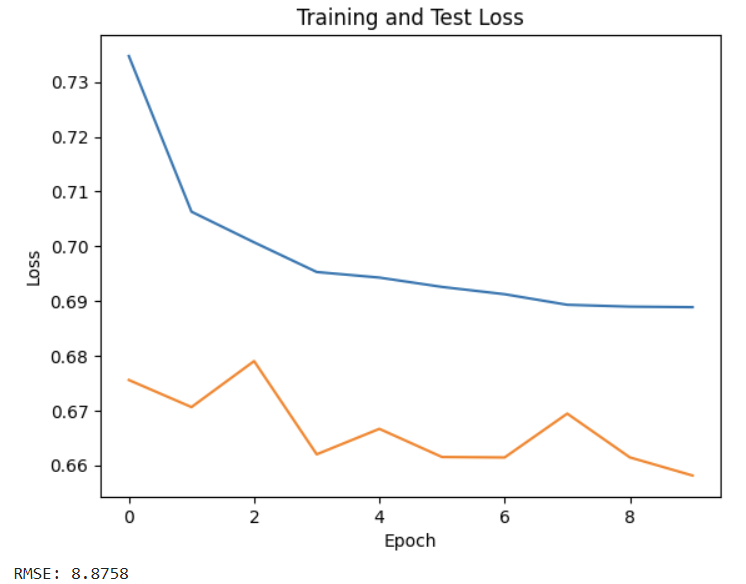

RMSE увеличилось, но судя по графику переобучение снизилось, попробуем увеличить количество эпох до 15 и добавим еще один слой, получим трехслойную сеть   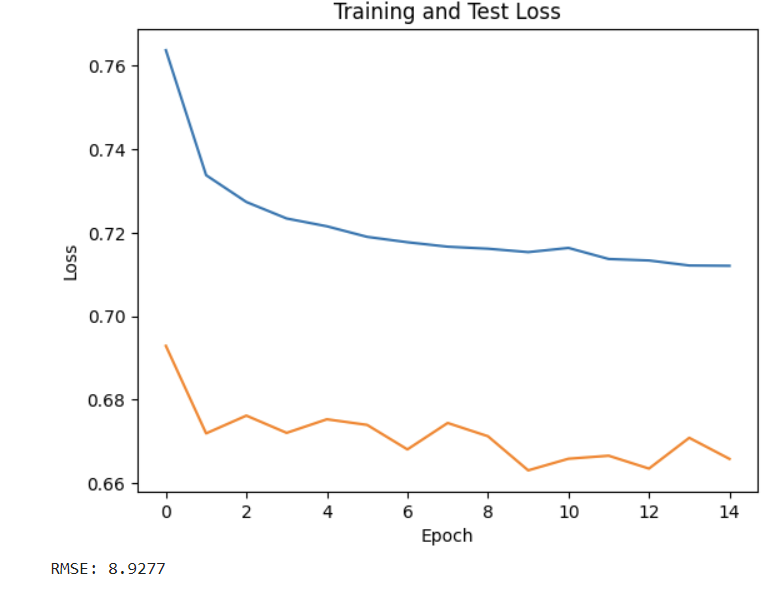

Качество ухудшилось и видно, что от количества эпох качество не увеличивается и только занимает больше времени обучения, попробуем снизить количество эпох до 6, убрать третий слой и добавить weight_decay=0.01 в оптимизатор 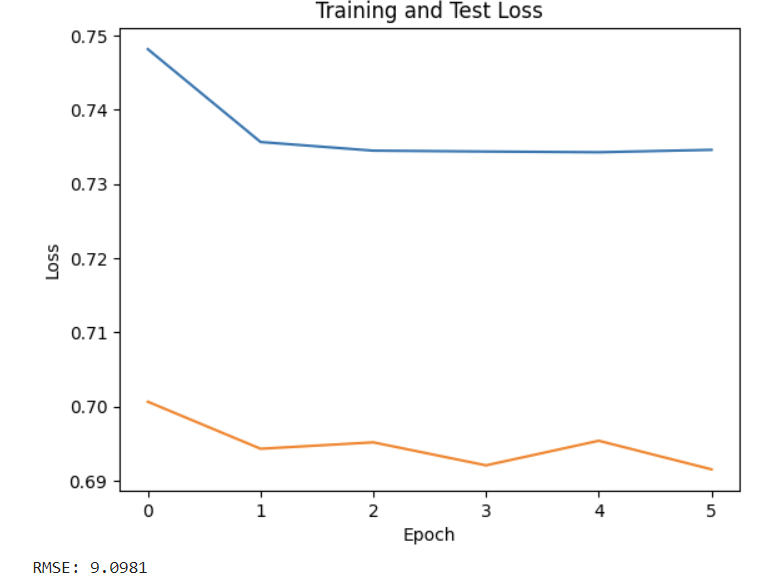

😞😞😞😞😞 уберем dropout и weight decay, попробуем увеличить количество слоев до 4 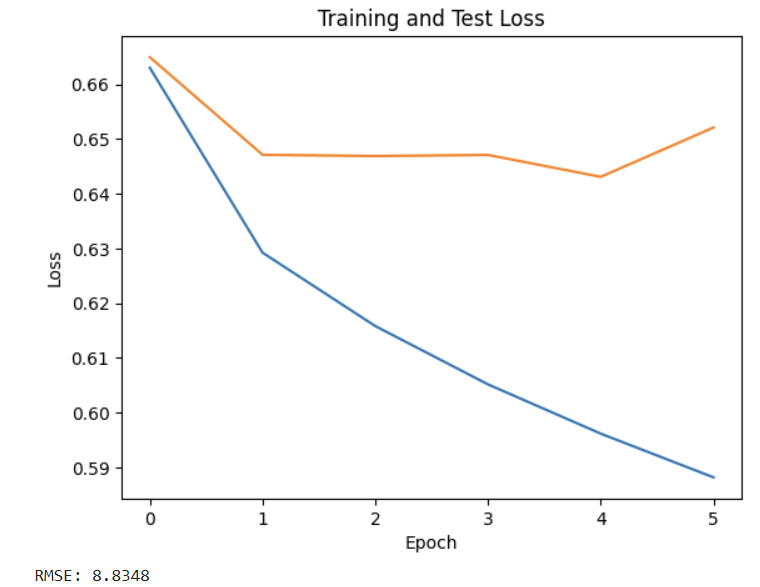

увеличим выходы на слоях 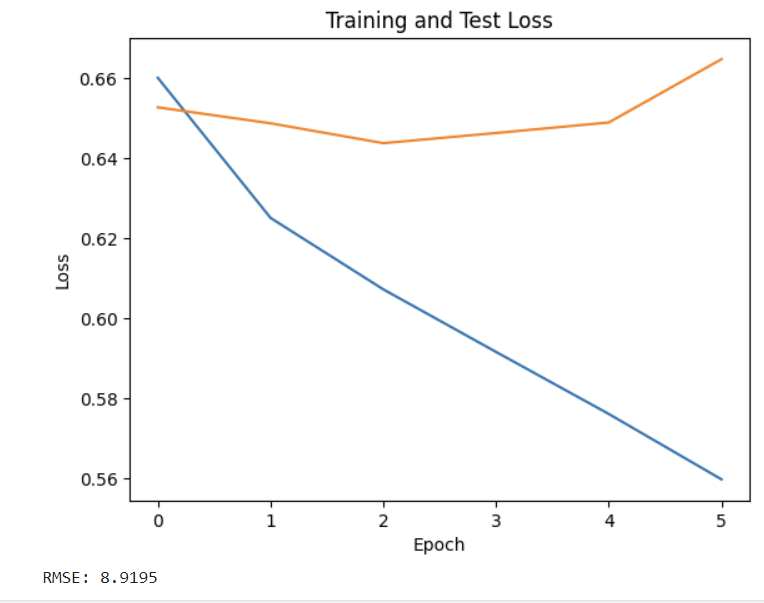

еще попробуем поэкспериментировать с выходами и слоями (особо лучше не стало от прошлой 4 слойной), не стала выводить


```
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(X.shape[1], 216),  
            nn.ReLU(),
            nn.Linear(216, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)

```

Итак, было проведено еще много экспериментов (все не стала вставлять) и в итоге получилось 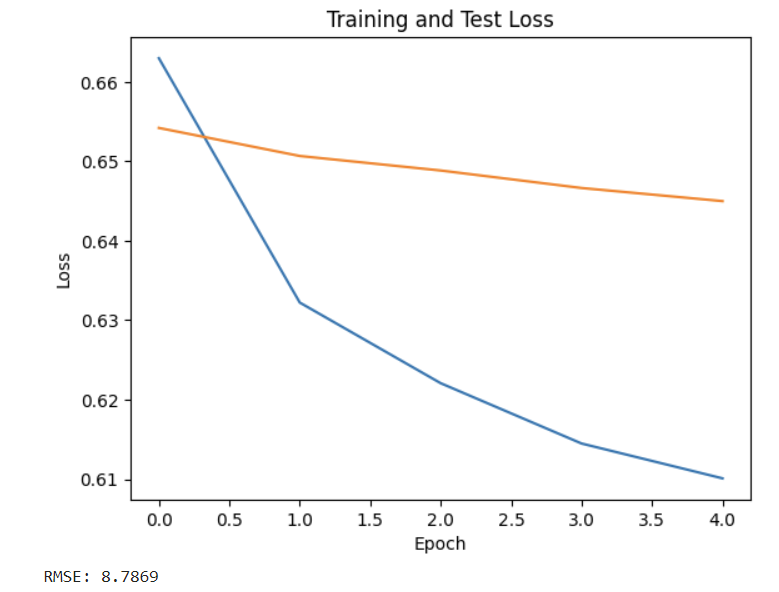

Измененные параметры:

1.   batch_size=64 (увеличен)
2.   lr=0.001 (увеличен)
3.   количество эпох - 5
4.   4 слоя, выходы:


```
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(X.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
```









## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

Так как у нас много мелких классов и они важны, будем использовать макро усреднение

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from torch.utils.data import TensorDataset

y_train = y[:train_size]
y_test = y[train_size:]

In [96]:
class ClassificationModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ClassificationModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, output_size)
        )

    def forward(self, x):
        return self.fc(x)

def train_model(model, criterion, optimizer, train_loader, epochs=5):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
        print(f'Epoch {epoch + 1}, Loss: {total_loss/len(train_loader)}')

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss на разных эпохах')
    plt.show()

def test_classification(model, criterion, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    return all_labels, all_preds

In [97]:
# год за отдельный класс
unique_years = sorted(set(y_train))
year_to_class = {year: idx for idx, year in enumerate(unique_years)}
y_train_class = torch.tensor([year_to_class[year] for year in y_train], dtype=torch.long)
y_test_class = torch.tensor([year_to_class[year] for year in y_test], dtype=torch.long)
n_of_unique_years= len(unique_years)

In [98]:
train_dataset_years = TensorDataset(torch.tensor(X_train, dtype=torch.float32), y_train_class)
test_dataset_years = TensorDataset(torch.tensor(X_test, dtype=torch.float32), y_test_class)

train_loader_years = DataLoader(train_dataset_years, batch_size=64, shuffle=True)
test_loader_years = DataLoader(test_dataset_years, batch_size=64, shuffle=False)

In [99]:
model_years = ClassificationModel(input_size=X_train.shape[1], output_size=n_of_unique_years)
optimizer_years = optim.Adam(model_years.parameters(), lr=0.001)
criterion_years = nn.CrossEntropyLoss()

классификация по годам
Epoch 1, Loss: 3.187066971877317
Epoch 2, Loss: 3.1000314417577663
Epoch 3, Loss: 3.0802294788128957
Epoch 4, Loss: 3.0687008088312195
Epoch 5, Loss: 3.0611578767022607


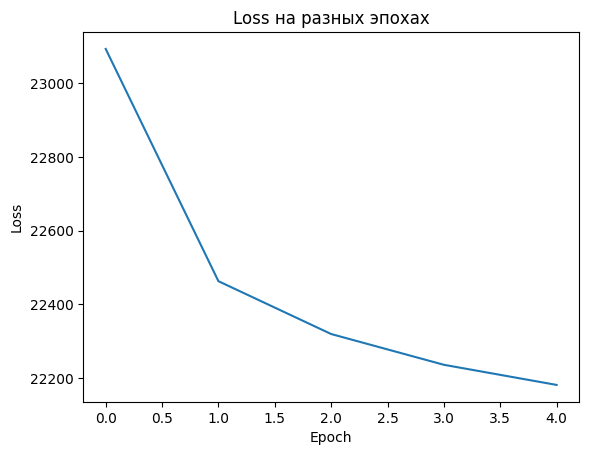

Метрики для классификации по годам:
Accuracy: 0.09215572341661825
Precision: 0.04220549351762375
Recall: 0.03618756371986005


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [100]:
print("классификация по годам")
train_model(model_years, criterion_years, optimizer_years, train_loader_years)

true_labels_years, predicted_labels_years = test_classification(model_years, criterion_years, test_loader_years)
accuracy_years = accuracy_score(true_labels_years, predicted_labels_years)
precision_years = precision_score(true_labels_years, predicted_labels_years, average='macro')
recall_years = recall_score(true_labels_years, predicted_labels_years, average='macro')
print(f"Метрики для классификации по годам:")
print(f"Accuracy: {accuracy_years}")
print(f"Precision: {precision_years}")
print(f"Recall: {recall_years}")

In [101]:
# задача классификации для 10 кассов
bins_train = pd.cut(y_train, bins=10, labels=False)
bins_test = pd.cut(y_test, bins=10, labels=False)

y_train_bins = torch.tensor(bins_train, dtype=torch.long)
y_test_bins = torch.tensor(bins_test, dtype=torch.long)

In [102]:
train_dataset_bins = TensorDataset(torch.tensor(X_train, dtype=torch.float32), y_train_bins)
test_dataset_bins = TensorDataset(torch.tensor(X_test, dtype=torch.float32), y_test_bins)

train_loader_bins = DataLoader(train_dataset_bins, batch_size=64, shuffle=True)
test_loader_bins = DataLoader(test_dataset_bins, batch_size=64, shuffle=False)

In [103]:
model_bins = ClassificationModel(input_size=X_train.shape[1], output_size=10)
optimizer_bins = optim.Adam(model_bins.parameters(), lr=0.001)
criterion_bins = nn.CrossEntropyLoss()

классификация по 10 бинам
Epoch 1, Loss: 1.0896763303662873
Epoch 2, Loss: 1.042361292240536
Epoch 3, Loss: 1.0302504640223735
Epoch 4, Loss: 1.0230089096923642
Epoch 5, Loss: 1.0172098157009695


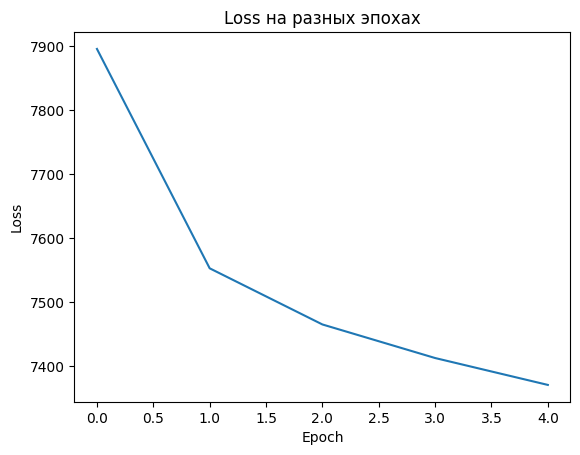

Метрики для классификации по годам:
Accuracy: 0.5826070114274646
Precision: 0.25088618639826565
Recall: 0.21517049765421065


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [104]:
print("классификация по 10 бинам")
train_model(model_bins, criterion_bins, optimizer_bins, train_loader_bins)

true_labels_bins, predicted_labels_bins = test_classification(model_bins, criterion_bins, test_loader_bins)
accuracy_bins = accuracy_score(true_labels_bins, predicted_labels_bins)
precision_bins = precision_score(true_labels_bins, predicted_labels_bins, average='macro')
recall_bins = recall_score(true_labels_bins, predicted_labels_bins, average='macro')
print(f"Метрики для классификации по годам:")
print(f"Accuracy: {accuracy_bins}")
print(f"Precision: {precision_bins}")
print(f"Recall: {recall_bins}")

Вывод: метрики качества заметно луше при классификации на 10 бинах, что логично,так как нужно предсказать не конкретный год, а только промежуток.

Однако качество обеих моделей оставляет желать лучшего: у первой accuracy 0,01,она совсем плохо предсказывает год выпуска песни

у второй accuracy - 0.59, все еще мало, и судя по recall модель всё же пропускает правильные классы в значительной части случаев. (но насколько я поняла не было цели выбить качество)

Возможно такое качество связано с недостаточной сложностью модели

Для многоклассовой классификации часто используется categorical cross-entropy, для регрессии чаще применяется mean squared error (MSE) (поэтому функция потерь изменена)

Также при классификации число нейронов в выходном слое равно количеству классов, в регрессии - 1 нейрон на выходе (если не нужно предсказать вектор, но это не наш случай)